In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import itertools
import holidays
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error as mape

In [10]:
# Preprocess the pizza sales dataset
def preprocess_pizza_sales(df):
    # Fill missing values for key columns using forward fill
    df['pizza_name_id'] = df['pizza_name_id'].ffill()
    df['pizza_ingredients'] = df['pizza_ingredients'].ffill()
    df['pizza_name'] = df['pizza_name'].ffill()
    
    # Calculate total price where missing
    df['total_price'] = df['total_price'].fillna(df['quantity'] * df['unit_price'])
    
    # Fill missing pizza category with 'Unknown'
    df['pizza_category'] = df['pizza_category'].fillna('Unknown')
    
    # Ensure the 'order_date' column is in datetime format
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    
    # Handle invalid dates (if any) and drop rows with null 'order_date'
    df = df.dropna(subset=['order_date'])
    
    # Create a new column for the week number
    df['week'] = df['order_date'].dt.isocalendar().week
    
    return df

In [11]:
# Group pizza sales data by week and analyze pizza quantities sold by pizza type and size
def group_sales_by_week(df):
    # Group by week, pizza_name, and pizza_size to calculate total quantity sold for each pizza
    weekly_sale = df.groupby(['week', 'pizza_name', 'pizza_size'])['quantity'].sum().reset_index()
    
    # Sort the data for better visualization
    weekly_sale = weekly_sale.sort_values(by=['week', 'pizza_name', 'pizza_size'])
    
    # Show the aggregated data for review
    print("Weekly Pizza Sales (Aggregated by pizza type and size):")
    print(weekly_sale)
    
    return weekly_sale

In [12]:
def eda_ingredients(df):
    # Summary statistics
    print("Summary statistics for Pizza Ingredients Dataset:")
    print(df.describe(include='all'))
    
    # Total Quantity of ingredients used in grams - Top 15 (Bar plot)
    plt.figure(figsize=(10, 6))
    top_15_ingredient_qty = df.groupby('pizza_ingredients')['Items_Qty_In_Grams'].sum().nlargest(15).reset_index()
    sns.barplot(x='Items_Qty_In_Grams', y='pizza_ingredients', data=top_15_ingredient_qty, palette='coolwarm')
    plt.title('Top 15 Ingredients by Total Quantity Used (in grams)')
    plt.xlabel('Total Quantity (grams)')
    plt.ylabel('Ingredients')
    plt.show()
    
    # Total quantity of ingredients used per pizza - Top 15 (Bar plot)
    total_ingredient_qty = df.groupby('pizza_name')['Items_Qty_In_Grams'].sum().nlargest(15).reset_index()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Items_Qty_In_Grams', y='pizza_name', data=total_ingredient_qty, palette='Spectral')
    plt.title('Top 15 Pizzas by Total Quantity of Ingredients Used (in grams)')
    plt.xlabel('Total Quantity (grams)')
    plt.ylabel('Pizza Name')
    plt.show()

In [13]:
def eda_pizza_sales(df):
    # Select the main necessary columns for summary statistics
    columns_to_include = ['pizza_name_id', 'quantity', 'unit_price', 'total_price', 'pizza_size', 'pizza_category', 'pizza_ingredients', 'day_of_week', 'month', 'is_holiday']

    # Summary statistics for the selected columns
    print("Summary statistics for selected columns in Pizza Sales Dataset:")
    print(df[columns_to_include].describe(include='all'))

    # Distribution of top 15 pizza names
    plt.figure(figsize=(10, 6))
    top_15_pizzas = df['pizza_name'].value_counts().nlargest(15).index  # Get top 15 pizza names
    sns.countplot(y='pizza_name', data=df[df['pizza_name'].isin(top_15_pizzas)], order=top_15_pizzas)
    plt.title('Distribution of Top 15 Pizza Names')
    plt.show()

    # Distribution of specific pizza categories
    plt.figure(figsize=(10, 6))
    valid_categories = ['Classic', 'Supreme', 'Veggie', 'Chicken']  # List of valid categories
    filtered_df = df[df['pizza_category'].isin(valid_categories)]  # Filter out unwanted categories
    sns.countplot(y='pizza_category', data=filtered_df, order=filtered_df['pizza_category'].value_counts().index)
    plt.title('Distribution of Pizza Categories (Filtered)')
    plt.show()

    # Sales trends over time
    df['order_date'] = pd.to_datetime(df['order_date'])
    df_daily_sales = df.groupby('order_date')['quantity'].sum().reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(x='order_date', y='quantity', data=df_daily_sales)
    plt.title('Daily Pizza Sales Over Time')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.show()

In [14]:
def is_holiday(date, holiday_list):
    """Check if a given date is a holiday."""
    return date in holiday_list

def feature_engineering(df, holiday_dates_list):
    # Reset index to move 'order_date' from index to a column
    df = df.reset_index(drop=True)
    
    # Ensure 'order_date' is in datetime format
    df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
    
    # Extract day of the week and month
    df['day_of_week'] = df['order_date'].dt.dayofweek  # Monday=0, Sunday=6
    df['month'] = df['order_date'].dt.month
    
    # Check if each date is a holiday (compare only date part, not time)
    df['is_holiday'] = df['order_date'].dt.date.apply(lambda x: is_holiday(x, holiday_dates_list)).astype(int)
    
    print("Feature Engineering Completed.\n")
    return df

In [15]:
# Load the datasets (replace the file paths with appropriate ones)
pizza_sales = pd.read_excel("C:/Users/MR/Desktop/Dominos/finalone/Pizza_Sale.xlsx")
ingredients = pd.read_excel("C:/Users/MR/Desktop/Dominos/finalone/Pizza_ingredients.xlsx")

In [16]:
# Define the country and years for holidays
country = 'USA'
years = [2015]

# Generate holiday dates for the specified years and country
holiday_dates = holidays.CountryHoliday(country, years=years)

# Convert holiday dates to a list
holiday_dates_list = [date for date in holiday_dates.keys()]

# Feature Engineering on pizza sales
pizza_sales = feature_engineering(pizza_sales, holiday_dates_list)

# Display the DataFrame with new features
pizza_sales

Feature Engineering Completed.



,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,day_of_week,month,is_holiday
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,3,1,1
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,3,1,1
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,3,1,1
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,3,1,1
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,2015-12-31,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza,3,12,0
48616,48617,21348,four_cheese_l,1,2015-12-31,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza,3,12,0
48617,48618,21348,napolitana_s,1,2015-12-31,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,3,12,0
48618,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,3,12,0


Summary statistics for selected columns in Pizza Sales Dataset:
       pizza_name_id      quantity    unit_price   total_price pizza_size  \
count          48620  48620.000000  48620.000000  48620.000000      48620   
unique            91           NaN           NaN           NaN          5   
top       big_meat_s           NaN           NaN           NaN          L   
freq            1817           NaN           NaN           NaN      18526   
mean             NaN      1.019622     16.494132     16.821474        NaN   
std              NaN      0.143077      3.621789      4.437398        NaN   
min              NaN      1.000000      9.750000      9.750000        NaN   
25%              NaN      1.000000     12.750000     12.750000        NaN   
50%              NaN      1.000000     16.500000     16.500000        NaN   
75%              NaN      1.000000     20.250000     20.500000        NaN   
max              NaN      4.000000     35.950000     83.000000        NaN   

       pizz

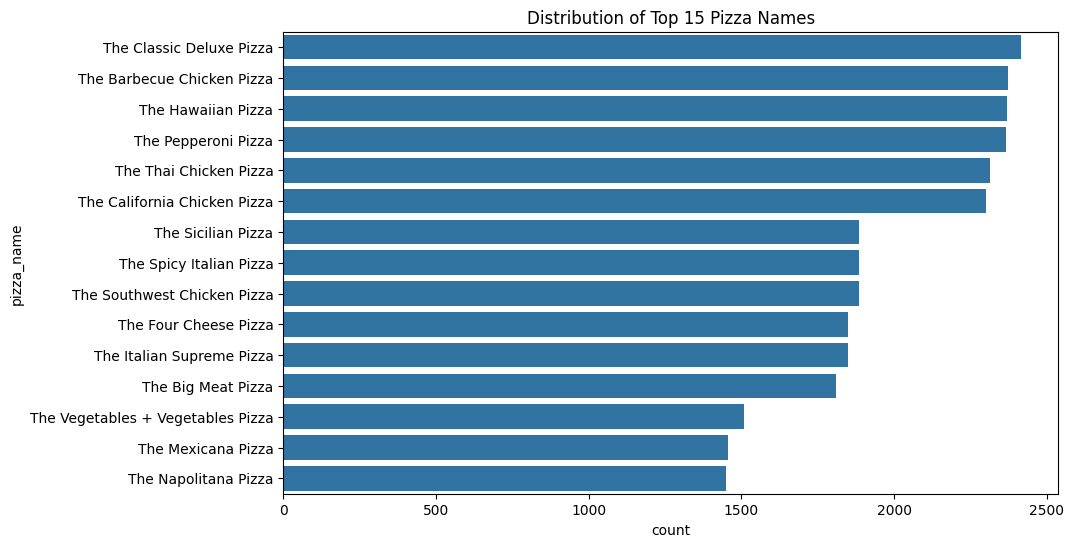

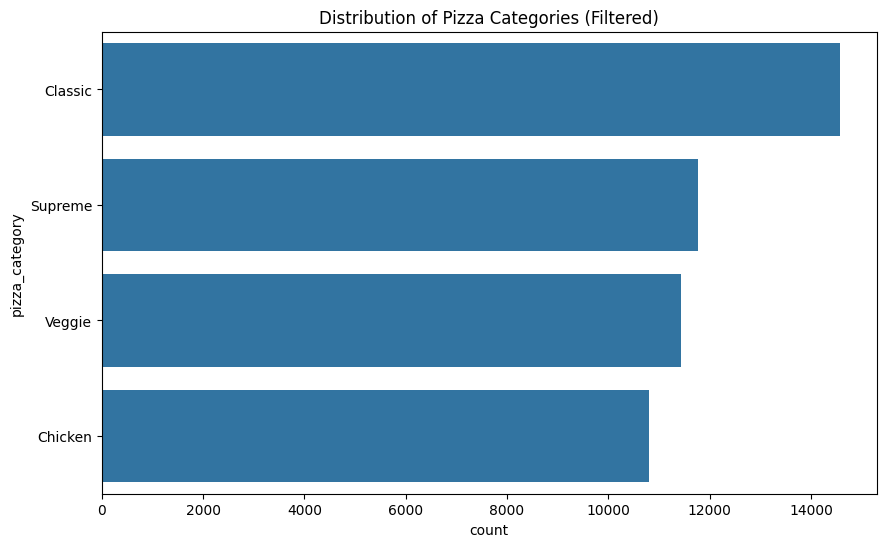

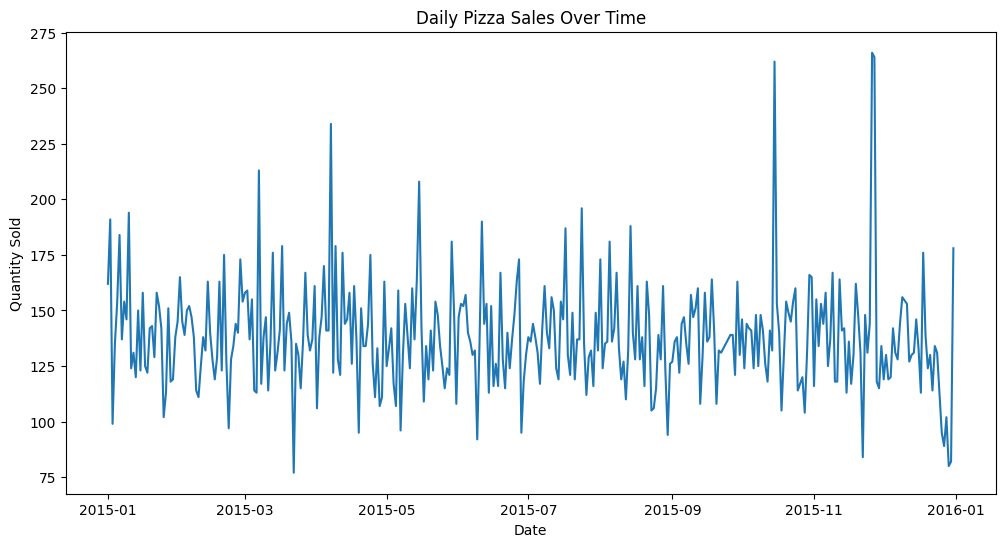

Summary statistics for Pizza Ingredients Dataset:
       pizza_name_id       pizza_name pizza_ingredients  Items_Qty_In_Grams
count            518              518               518          514.000000
unique            91               32                64                 NaN
top     veggie_veg_s  The Greek Pizza            Garlic                 NaN
freq               8               30                57                 NaN
mean             NaN              NaN               NaN           30.564202
std              NaN              NaN               NaN           30.351623
min              NaN              NaN               NaN            5.000000
25%              NaN              NaN               NaN           10.000000
50%              NaN              NaN               NaN           20.000000
75%              NaN              NaN               NaN           40.000000
max              NaN              NaN               NaN          200.000000


C:\Users\MR\AppData\Local\Temp\ipykernel_10636\2010387937.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Items_Qty_In_Grams', y='pizza_ingredients', data=top_15_ingredient_qty, palette='coolwarm')


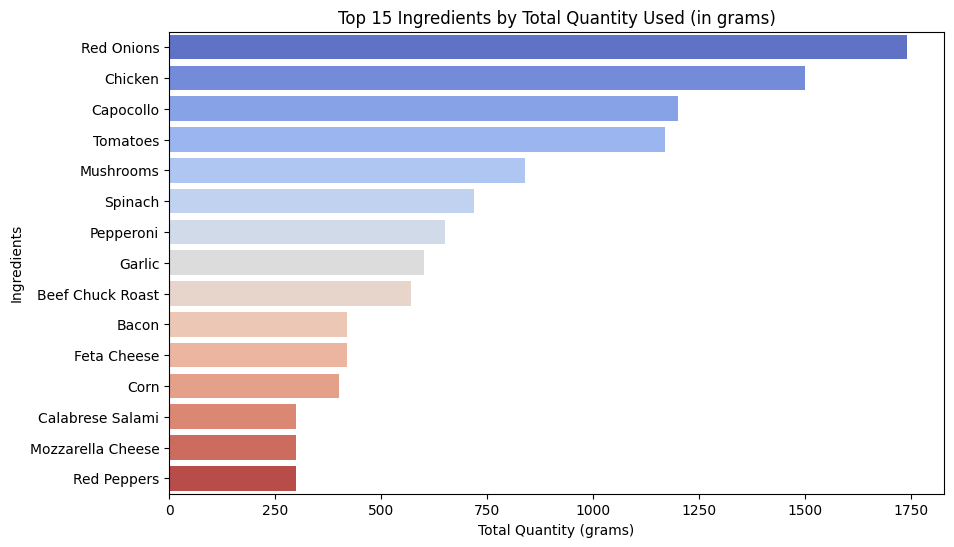

C:\Users\MR\AppData\Local\Temp\ipykernel_10636\2010387937.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Items_Qty_In_Grams', y='pizza_name', data=total_ingredient_qty, palette='Spectral')


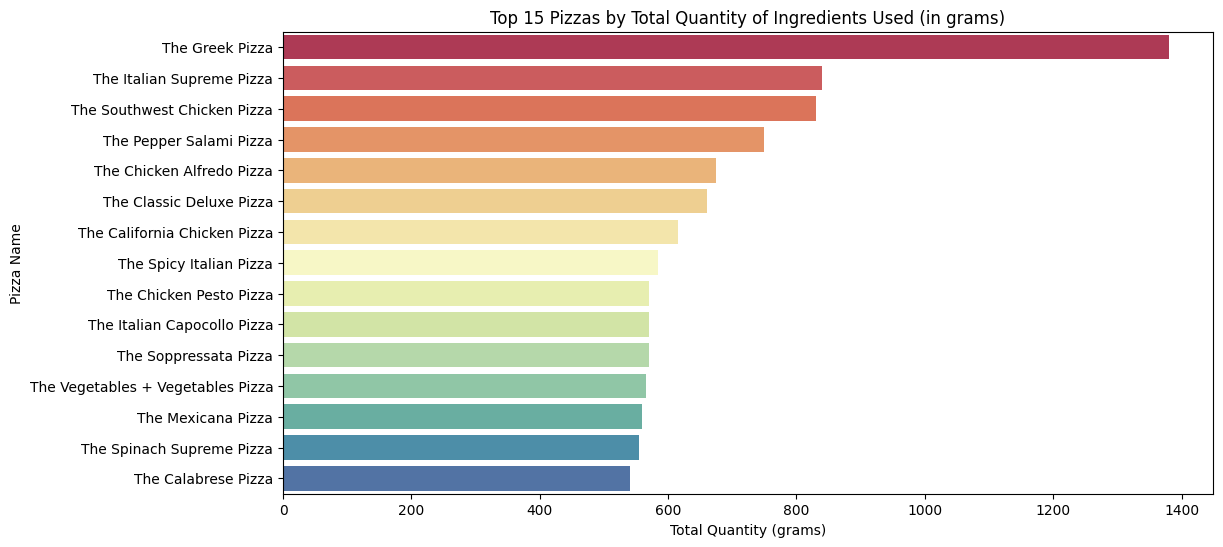

In [17]:
# Preprocess the pizza sales dataset
pizza_sales = preprocess_pizza_sales(pizza_sales)

# Perform EDA on pizza sales and ingredients datasets
eda_pizza_sales(pizza_sales)
eda_ingredients(ingredients)

In [18]:
# Step 1: Filter the pizza_sales dataset for any week(week 7):
week_7_sales = pizza_sales[pizza_sales['week'] == 7]

# Step 2: Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# Step 3: List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Step 4: Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 65 pizzas
The Big Meat Pizza: 32 pizzas
The Brie Carre Pizza: 8 pizzas
The Calabrese Pizza: 22 pizzas
The California Chicken Pizza: 47 pizzas
The Chicken Alfredo Pizza: 27 pizzas
The Chicken Pesto Pizza: 16 pizzas
The Classic Deluxe Pizza: 44 pizzas
The Five Cheese Pizza: 29 pizzas
The Four Cheese Pizza: 37 pizzas
The Greek Pizza: 31 pizzas
The Green Garden Pizza: 19 pizzas
The Hawaiian Pizza: 35 pizzas
The Italian Capocollo Pizza: 33 pizzas
The Italian Supreme Pizza: 37 pizzas
The Italian Vegetables Pizza: 16 pizzas
The Mediterranean Pizza: 15 pizzas
The Mexicana Pizza: 35 pizzas
The Napolitana Pizza: 17 pizzas
The Pepper Salami Pizza: 16 pizzas
The Pepperoni Pizza: 49 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 22 pizzas
The Prosciutto and Arugula Pizza: 31 pizzas
The Sicilian Pizza: 44 pizzas
The Soppressata Pizza: 17 pizzas
The Southwest Chicken Pizza: 34 pizzas
The Spicy Italian Pizza: 34 pizzas
The Spinach Pesto Pizza: 14 

In [19]:
# ARIMA Model Tuning

# Suppress warnings
warnings.filterwarnings("ignore")

# Step 1: Data Preparation - Aggregate pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Assuming pizza_sales is your main dataframe
pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# Step 2: Split data into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Define MAPE function
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Step 3: Tune ARIMA Model
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model: {best_score:.2f}")
    return best_predictions, best_score

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score = tune_arima_model(train, test, p_values, d_values, q_values)

Best ARIMA Model: 0.19


In [20]:
# SARIMA Model Tuning

# Suppress warnings
warnings.filterwarnings("ignore")

# Step 1: Data Preparation - Aggregate pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

# Assuming pizza_sales is your main dataframe
pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# Step 2: Split data into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Define MAPE function
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Step 3: Best SARIMA Model Training
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)
    print(f"Best SARIMA MAPE: {sarima_mape:.2f}")
    return predictions, sarima_mape

sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

Best SARIMA MAPE: 0.20


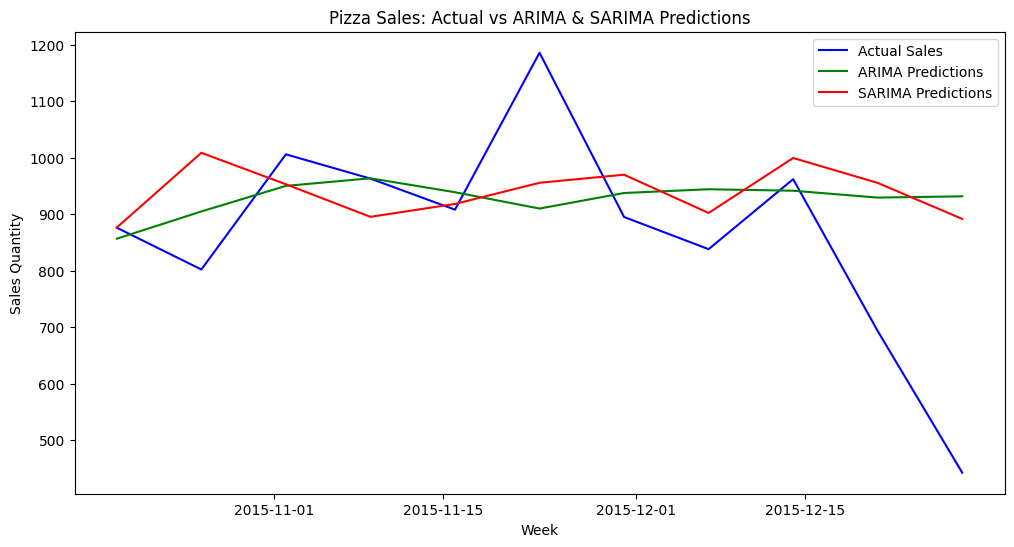

In [21]:

# Visualization of ARIMA and SARIMA Predictions vs Actual Sales
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Sales', color='blue')
plt.plot(test.index, arima_predictions, label='ARIMA Predictions', color='green')
plt.plot(test.index, sarima_predictions, label='SARIMA Predictions', color='red')
plt.title('Pizza Sales: Actual vs ARIMA & SARIMA Predictions')
plt.xlabel('Week')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()

In [22]:
# SARIMA Model forecasted sales for the week:

# Suppress warnings
warnings.filterwarnings("ignore")

# Step 1: Data Preparation - Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Step 2: Create a function to forecast for each pizza type
def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    # Train the SARIMA model
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    # Forecast for the next week
    forecast = model_fit.forecast(steps=periods)
    
    # Convert the forecast to a list (if it's not already)
    return pizza_type, forecast.tolist()

# Step 3: Forecast for each pizza type for the next week
def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    # Dictionary to store the forecasted sales for each pizza type
    pizza_type_forecasts = {}

    # Calculate total sales per pizza type and the week range
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Get the last week's date range (for prediction display purposes)
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Loop through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        # Filter the data for this pizza type
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]
        
        # Split into training data
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales for the next week for this pizza type
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        # Store the forecast in the dictionary
        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Step 4: Forecast pizza sales for the next week
next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

# Display the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0  # To accumulate the forecasted quantities

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

# Display the total quantity of units sold in the predicted week
print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 13 pizzas
bbq_ckn_m: 22 pizzas
bbq_ckn_s: 10 pizzas
big_meat_s: 35 pizzas
brie_carre_s: 11 pizzas
calabrese_l: 3 pizzas
calabrese_m: 8 pizzas
cali_ckn_l: 19 pizzas
cali_ckn_m: 16 pizzas
cali_ckn_s: 8 pizzas
ckn_alfredo_l: 3 pizzas
ckn_alfredo_m: 12 pizzas
ckn_alfredo_s: 2 pizzas
ckn_pesto_l: 8 pizzas
ckn_pesto_m: 4 pizzas
ckn_pesto_s: 3 pizzas
classic_dlx_l: 9 pizzas
classic_dlx_m: 22 pizzas
classic_dlx_s: 14 pizzas
five_cheese_l: 23 pizzas
four_cheese_l: 33 pizzas
four_cheese_m: 11 pizzas
green_garden_l: 1 pizzas
green_garden_m: 9 pizzas
green_garden_s: 10 pizzas
hawaiian_l: 15 pizzas
hawaiian_m: 5 pizzas
hawaiian_s: 16 pizzas
ital_cpcllo_l: 14 pizzas
ital_cpcllo_m: 12 pizzas
ital_cpcllo_s: 8 pizzas
ital_supr_l: 14 pizzas
ital_supr_m: 17 pizzas
ital_supr_s: 2 pizzas
ital_veggie_m: 10 pizzas
ital_veggie_s: 4 pizzas
mediterraneo_l: 7 pizzas
mediterraneo_m: 7 pizzas
mediterraneo_s: 6 pizzas
mexicana_l: 14 pizzas
mexicana_

In [23]:
# ARIMA Model forecasted sales for the week:

# Suppress warnings
warnings.filterwarnings("ignore")

# Step 1: Data Preparation - Aggregate pizza sales by week and pizza type
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Step 2: Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    # Train the ARIMA model (order similar to SARIMAX but no seasonality)
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Step 3: Forecast next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Calculate total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Get the last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Loop through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        # Filter data for this pizza type
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Split the data into training set (80% of the data)
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Step 4: Forecast pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Display the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 18 pizzas
bbq_ckn_m: 18 pizzas
bbq_ckn_s: 9 pizzas
big_meat_s: 36 pizzas
brie_carre_s: 9 pizzas
calabrese_l: 4 pizzas
calabrese_m: 10 pizzas
cali_ckn_l: 17 pizzas
cali_ckn_m: 19 pizzas
cali_ckn_s: 10 pizzas
ckn_alfredo_l: 3 pizzas
ckn_alfredo_m: 13 pizzas
ckn_alfredo_s: 2 pizzas
ckn_pesto_l: 7 pizzas
ckn_pesto_m: 4 pizzas
ckn_pesto_s: 5 pizzas
classic_dlx_l: 10 pizzas
classic_dlx_m: 22 pizzas
classic_dlx_s: 15 pizzas
five_cheese_l: 27 pizzas
four_cheese_l: 24 pizzas
four_cheese_m: 11 pizzas
green_garden_l: 2 pizzas
green_garden_m: 5 pizzas
green_garden_s: 11 pizzas
hawaiian_l: 16 pizzas
hawaiian_m: 9 pizzas
hawaiian_s: 18 pizzas
ital_cpcllo_l: 14 pizzas
ital_cpcllo_m: 6 pizzas
ital_cpcllo_s: 5 pizzas
ital_supr_l: 13 pizzas
ital_supr_m: 17 pizzas
ital_supr_s: 3 pizzas
ital_veggie_m: 9 pizzas
ital_veggie_s: 5 pizzas
mediterraneo_l: 6 pizzas
mediterraneo_m: 5 pizzas
mediterraneo_s: 7 pizzas
mexicana_l: 16 pizzas
mexicana_m

In [24]:
# Displaying the total quantity of predicted ingredients

# Copy ingredients, map predicted sales, and calculate total ingredient quantity
ingredients_predicted = ingredients.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum up the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:
{'?duja Salami': 680.0, 'Alfredo Sauce': 275.0, 'Anchovies': 815.0, 'Artichokes': 2315.0, 'Arugula': 270.0, 'Asiago Cheese': 1220.0, 'Bacon': 9550.0, 'Barbecue Sauce': 495.0, 'Barbecued Chicken': 1440.0, 'Beef Chuck Roast': 2500.0, 'Blue Cheese': 810.0, 'Brie Carre Cheese': 270.0, 'Calabrese Salami': 3800.0, 'Capocollo': 13450.0, 'Caramelized Onions': 0.0, 'Chicken': 18000.0, 'Chipotle Sauce': 1550.0, 'Chorizo Sausage': 1800.0, 'Cilantro': 775.0, 'Coarse Sicilian Salami': 2760.0, 'Corn': 5200.0, 'Eggplant': 640.0, 'Feta Cheese': 2190.0, 'Fontina Cheese': 1370.0, 'Friggitello Peppers': 170.0, 'Garlic': 5635.0, 'Genoa Salami': 1590.0, 'Goat Cheese': 2800.0, 'Gorgonzola Piccante Cheese': 1180.0, 'Gouda Cheese': 990.0, 'Green Olives': 1150.0, 'Green Peppers': 1775.0, 'Italian Sausage': 360.0, 'Jalapeno Peppers': 1270.0, 'Kalamata Olives': 670.0, 'Luganega Sausage': 1380.0, 'Mozzarella Cheese': 4080.0, 'Mushrooms': 6900.0, 'Oni

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,18,720.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,18,270.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,18,360.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,18,540.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,18,1080.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,8,160.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,8,160.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,8,80.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,8,120.0
